<a href="https://colab.research.google.com/github/BedinEduardo/Colab_Repositories/blob/master/Image_Video_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Computer Vision Tutorial

In this tutorial, you will learn how to train a CNN for image classification using transfer learning. You can read more about transfer learning at **cs231 notes**,

Quoting these notes,

  In practice, very few people train an entire CNN from scratch - random initialization, relatively rare to have a dataset of sufficient size. It is commong to pretrain a CNN on a dataset over 1M images, and then used the pretrained CNN either as initialization or a fixed exractor for the task of interest.

  These two major transfer learning scenarios look as follows>

  * **Finetuning the CNN**: instead of random initialization, we initialize the NN with a pretrained network, like the one that is trained on ImageNet 1000 dataset. Rest of the training look as usual.
  * **CNN as fixed feature extractor**: Here, we will freeze the weights for all of the NN excep tha of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
#import torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()  # interactive mode

## Load Data

We will use torchvision and `torch.utils.data` package for loading the data.

The problem we are going to solve today is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation image for each class.

In [ ]:
!wget "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

--2025-06-23 13:06:23--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.160.32, 3.165.160.20, 3.165.160.85, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.160.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   195MB/s    in 0.2s    

2025-06-23 13:06:24 (195 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
# data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    }

In [ ]:
data_dir  ='hymenoptera_data'

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
for x in ['train', 'val']}

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
for x in ['train','val']}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
data_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

In [ ]:
class_names = image_datasets['train'].classes

In [ ]:
print(class_names)

['ants', 'bees']


In [ ]:
print(data_sizes)

{'train': 244, 'val': 153}


In [ ]:
# we want to be able to train our model on an 'accelerator'
# <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it, otherwise 'cpu'
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'

print(f"Using: {device}")

Using: cuda


## Visualize a few images

Few training images so as to understand the data augmentation

In [ ]:
def imshow(inp, title=None):
  """
  Display iamges for Tensor

  """

  inp = inp.numpy().transpose((1,2,0))  # RGB -> GBR
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated

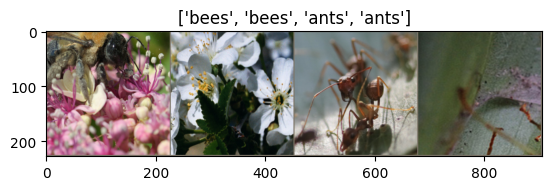

In [ ]:
# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#make grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now let's write a general function to train a model. Here, we will illustrate

* Scheduling the learning rate
* Saving the best model

`scheduler` is a LR scheduler object from `torch.optim.lr_scheduler`

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()

  # Build a temporary directory to save training chekpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range (num_epochs):
      print(f"Epoch {epoch} / {num_epochs}")
      print('-'*10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()  # set to train
        else:
          model.eval()  # set to evaluation

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

          # backward + optimze only if in training phase
            if phase == 'train':
              loss.backward()  # computes the gradient of current tensor wrt graph leaves.
              optimizer.step()  # Perform a single optiimzation step to update parameter

        # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
          scheduler.step()  # adjust LR

        epoch_loss = running_loss / data_sizes[phase]
        epoch_acc = running_corrects.double() / data_sizes[phase]

        print(f"{phase} Loss: {epoch_loss:.4f} / Acc: {epoch_acc:.3f}")

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f"Best val Acc: {best_acc:.4f}")

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

  return model



## Visualizing the model predictions

Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu()[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return

    model.train(mode=was_training)

## Finetunning the ConvNet

Load a pretrained model and reset final fully connected layeer

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to `nn.Linear(num_ftrs, len(class_names))
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Optimizer that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


## Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0 / 10
----------
train Loss: 0.5849 / Acc: 0.668
val Loss: 0.3862 / Acc: 0.843

Epoch 1 / 10
----------
train Loss: 0.5580 / Acc: 0.754
val Loss: 0.3788 / Acc: 0.876

Epoch 2 / 10
----------
train Loss: 0.5315 / Acc: 0.787
val Loss: 0.4199 / Acc: 0.850

Epoch 3 / 10
----------
train Loss: 0.4307 / Acc: 0.816
val Loss: 0.4536 / Acc: 0.824

Epoch 4 / 10
----------
train Loss: 0.4655 / Acc: 0.799
val Loss: 0.3567 / Acc: 0.882

Epoch 5 / 10
----------
train Loss: 0.4510 / Acc: 0.811
val Loss: 0.3888 / Acc: 0.824

Epoch 6 / 10
----------
train Loss: 0.5408 / Acc: 0.791
val Loss: 0.4705 / Acc: 0.837

Epoch 7 / 10
----------
train Loss: 0.4874 / Acc: 0.791
val Loss: 0.3115 / Acc: 0.876

Epoch 8 / 10
----------
train Loss: 0.3346 / Acc: 0.865
val Loss: 0.3105 / Acc: 0.869

Epoch 9 / 10
----------
train Loss: 0.2365 / Acc: 0.910
val Loss: 0.3312 / Acc: 0.882

Training complete in 0m 34s
Best val Acc: 0.8824


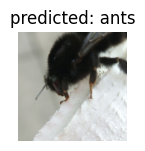

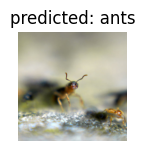

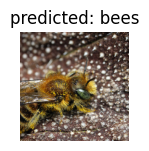

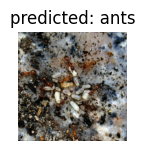

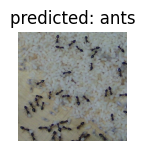

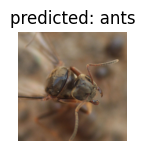

In [ ]:
# vizualize data
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network excpet the final layer. We need to set `requires_grad = False` to freeze the parameters so that the gradients are no computed in `backward()`.

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad = True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and Evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the NN, forward does need to be computed.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0 / 25
----------
train Loss: 0.5354 / Acc: 0.713
val Loss: 0.3936 / Acc: 0.824

Epoch 1 / 25
----------
train Loss: 0.6089 / Acc: 0.750
val Loss: 0.1829 / Acc: 0.935

Epoch 2 / 25
----------
train Loss: 0.6474 / Acc: 0.775
val Loss: 0.2287 / Acc: 0.935

Epoch 3 / 25
----------
train Loss: 0.3748 / Acc: 0.848
val Loss: 0.2853 / Acc: 0.908

Epoch 4 / 25
----------
train Loss: 0.5690 / Acc: 0.783
val Loss: 0.3429 / Acc: 0.850

Epoch 5 / 25
----------
train Loss: 0.4147 / Acc: 0.832
val Loss: 0.2151 / Acc: 0.935

Epoch 6 / 25
----------
train Loss: 0.4867 / Acc: 0.783
val Loss: 0.2245 / Acc: 0.941

Epoch 7 / 25
----------
train Loss: 0.3531 / Acc: 0.852
val Loss: 0.2314 / Acc: 0.941

Epoch 8 / 25
----------
train Loss: 0.4649 / Acc: 0.795
val Loss: 0.2262 / Acc: 0.935

Epoch 9 / 25
----------
train Loss: 0.3852 / Acc: 0.844
val Loss: 0.2006 / Acc: 0.941

Epoch 10 / 25
----------
train Loss: 0.3588 / Acc: 0.865
val Loss: 0.2047 / Acc: 0.948

Epoch 11 / 25
----------
train Loss: 0.373

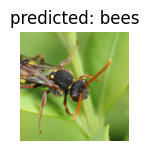

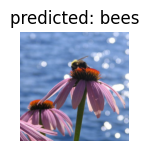

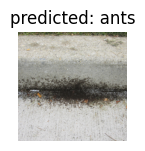

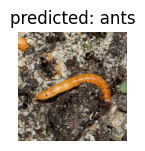

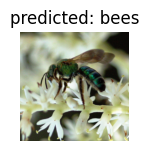

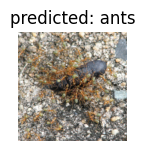

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on Custom Images

Use the trained model to make predictions on custom images and visualize the predicted class labels along with the images.

In [ ]:
def visualize_model_predictions(model, img_path):
  was_training = model.training
  model.eval()

  img = Image.open(img_path)
  img = data_transforms['val'](img)
  img = img.unsqueeze(0)
  img = img.to(device)

  with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

    ax = plt.subplot(2,2,1)
    ax.axis('off')
    ax.set_title(f'Predicted: {class_names[preds[0]]}')
    imshow(img.cpu().data[0])

    model.train(mode=was_training)

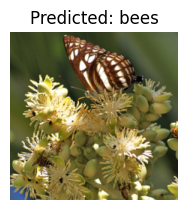

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path = 'hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)